In [1]:
import re
import random
import time
from statistics import mode

from PIL import Image, ImageStat
from tqdm import tqdm
import numpy as np
import pandas
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
def process_text_adv(text):
    # lowercase
    text = text.lower()

    # 数詞を数字に変換
    num_word_to_digit = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10', 
    }
    for word, digit in num_word_to_digit.items():
        text = text.replace(word, digit)

    # 小数点のピリオドを削除
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # 冠詞の削除
    text = re.sub(r'\b(a|an|the)\b', '', text)

    # 短縮形のカンマの追加
    contractions = {
        "dont": "don't", "isnt": "isn't", "arent": "aren't", "wont": "won't",
        "cant": "can't", "wouldnt": "wouldn't", "couldnt": "couldn't", "whats": "what's",
        "thats": "that's", "whos": "who's", "wheres": "where's", "whens": "when's",
        "please":"", "could you": "can you", "could i": "can i", "could we": "can we",
    }

    contractions_2 = {
        "theatre" : "theater", "colour" : "color", "centre" : "center", "favourite" : "favorite",
        "travelling" : "traveling", "counselling" : "counseling", "metre" : "meter",
        "cancelled" : "canceled", "labour" : "labor", "organisation" : "organization",
        "calibre" : "caliber", "cheque" : "check", "manoeuvre" : "maneuver",
        "neighbour" : "neighbor", "grey" : "gray", "dialogue" : "dialog",
    }

    contractions_3 = {
        "what is": "what's", "who is": "who's", "where is": "where's", "when is": "when's",
        "how is": "how's", "it is": "it's", "he is": "he's", "she is": "she's",
        "that is": "that's", "there is": "there's", "here is": "here's",
        "i am": "i'm", "you are": "you're", "we are": "we're", "they are": "they're",
        "i have": "i've", "you have": "you've", "we have": "we've", "they have": "they've",
        "i will": "i'll", "you will": "you'll",
    }
    # contractions_3 = {
    #     "what's" : "what is", "who's" : "who is", "where's" : "where is", "when's" : "when is",
    #     "how's" : "how is", "it's" : "it is", "he's" : "he is", "she's" : "she is",
    #     "that's" : "that is", "there's" : "there is", "here's" : "here is",
    #     "i'm" : "i am", "you're" : "you are", "we're" : "we are", "they're" : "they are",
    #     "i've" : "i have", "you've" : "you have", "we've" : "we have", "they've" : "they have",
    #     "i'll" : "i will", "you'll" : "you will",
    # }
 
    for contraction, correct in contractions.items():
        text = text.replace(contraction, correct)
    for contraction, correct in contractions_2.items():
        text = text.replace(contraction, correct)
    for contraction, correct in contractions_3.items():
        text = text.replace(contraction, correct)

    # 句読点をスペースに変換
    text = re.sub(r"[^\w\s':]", ' ', text)

    # 句読点をスペースに変換
    text = re.sub(r'\s+,', ',', text)

    # 連続するスペースを1つに変換
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [6]:
def process_text(text):
    # lowercase
    text = text.lower()

    # 数詞を数字に変換
    num_word_to_digit = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10'
    }
    for word, digit in num_word_to_digit.items():
        text = text.replace(word, digit)

    # 小数点のピリオドを削除
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # 冠詞の削除
    text = re.sub(r'\b(a|an|the)\b', '', text)

    # 短縮形のカンマの追加
    contractions = {
        "dont": "don't", "isnt": "isn't", "arent": "aren't", "wont": "won't",
        "cant": "can't", "wouldnt": "wouldn't", "couldnt": "couldn't"
    }
    for contraction, correct in contractions.items():
        text = text.replace(contraction, correct)

    # 句読点をスペースに変換
    text = re.sub(r"[^\w\s':]", ' ', text)

    # 句読点をスペースに変換
    text = re.sub(r'\s+,', ',', text)

    # 連続するスペースを1つに変換
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [7]:
# 1. データローダーの作成
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, transform_adv=None, answer=True):
        self.transform = transform  # 画像の前処理
        self.transform_adv = transform_adv  # 画像の前処理
        self.image_dir = image_dir  # 画像ファイルのディレクトリ
        self.df = pandas.read_json(df_path)  # 画像ファイルのパス，question, answerを持つDataFrame
        print(f"df shape: {self.df.shape}")
        
        self.answer = answer

        # question / answerの辞書を作成
        self.question2idx = {}
        self.answer2idx = {}
        self.idx2question = {}
        self.idx2answer = {}
        c1 = c2 = c3 = c4 = c5 = c6 = c7 = 0

        # 質問文の最大長を取得
        self.max_question_length = 0

        # 質問文に含まれる単語を辞書に追加
        for question in self.df["question"]:
            question = process_text_adv(question)
            words = question.split(" ")

            if len(words) > self.max_question_length:
                self.max_question_length = len(words)
            
            for idex, word in enumerate(words):            
                if word not in self.question2idx:
                    self.question2idx[word] = len(self.question2idx)

        
        self.idx2question = {v: k for k, v in self.question2idx.items()}  # 逆変換用の辞書(question)

        self.answer2idx["<unk>"] = 0

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

            # print(f"answer{self.idx2answer}")

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx, isKL=False):
        """
        対応するidxのデータ（画像，質問，回答）を取得．

        Parameters
        ----------
        idx : int
            取得するデータのインデックス

        Returns
        -------
        image : torch.Tensor  (C, H, W)
            画像データ
        question : torch.Tensor  (vocab_size)
            質問文をone-hot表現に変換したもの
        answers : torch.Tensor  (n_answer)
            10人の回答者の回答のid
        mode_answer_idx : torch.Tensor  (1)
            10人の回答者の回答の中で最頻値の回答のid
        """
        image = Image.open(f"{self.image_dir}/{self.df['image'][idx]}").convert("RGB")
        
        # image = self.transform(image)
        question = np.zeros(len(self.idx2question) + 1)  # 未知語用の要素を追加
        question_vector = []
        # question_words = self.df["question"][idx].split(" ")
        question_text = process_text_adv(self.df["question"][idx])
        question_words = question_text.split(" ")

        is_positional_question = False

        for i in range(self.max_question_length - len(question_words)):
            question_vector.insert(0, 0)
    
        for word in question_words:
            if not is_positional_question and (word == "where" or word == "right" or word == "left" or word == "top" or word == "bottom" or word == "position"):
                is_positional_question = True  
            try:
                question[self.question2idx[word]] = 1  # one-hot表現に変換
                question_vector.append(self.question2idx[word])
            except KeyError:
                question[-1] = 1  # 未知語
                question_vector.append(0)
        
        # if is_positional_question:
        #     print(f"positional question: {question_words}")
        # else:
        #     print(f"NOT positional question: {question_words}")

        if self.answer:
            answers_prevector = np.zeros(len(self.answer2idx))
                
            answers = [self.answer2idx[process_text(answer["answer"])]  if process_text(answer["answer"]) in self.answer2idx 
                       else 0 for answer in self.df["answers"][idx]]
            for answer in answers:
                answers_prevector[answer] += 1
            sum_answers = max(np.sum(answers_prevector), 1e-10)
            answers_vector = answers_prevector / sum_answers
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            if is_positional_question or self.transform_adv is None:
                image = self.transform(image)
            else:
                image = self.transform_adv(image)

            return image, torch.Tensor(question), torch.Tensor(answers), int(mode_answer_idx), torch.Tensor(answers_vector), torch.LongTensor(question_vector)

        else:

            if is_positional_question or self.transform_adv is None:
                image = self.transform(image)
            else:
                image = self.transform_adv(image)

            return image, torch.Tensor(question), torch.LongTensor(question_vector)

    def __len__(self):
        return len(self.df)

In [8]:
def loadVQAData(df_path, image_dir, transform=None, answer=True):
    return VQADataset(df_path, image_dir, transform, answer)

In [9]:
# 2. 評価指標の実装
# 簡単にするならBCEを利用する
def VQA_criterion(batch_pred: torch.Tensor, batch_answers: torch.Tensor):
    total_acc = 0.

    for pred, answers in zip(batch_pred, batch_answers):
        acc = 0.
        for i in range(len(answers)):
            num_match = 0
            for j in range(len(answers)):
                if i == j:
                    continue
                if pred == answers[j]:
                    num_match += 1
            acc += min(num_match / 3, 1)
        total_acc += acc / 10

    return total_acc / len(batch_pred)

In [10]:
# 3. モデルのの実装
# ResNetを利用できるようにしておく
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [11]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, layers):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], 64)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 512)

    def _make_layer(self, block, blocks, out_channels, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [13]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [14]:
def ResNet50():
    return ResNet(BottleneckBlock, [3, 4, 6, 3])

In [15]:
from torchvision.models import resnet34, ResNet34_Weights, Wide_ResNet50_2_Weights, wide_resnet50_2

class VQAModel(nn.Module):
    def __init__(self, vocab_size: int, n_answer: int):
        super().__init__()
        # self.resnet = ResNet18()
        self.resnet = torchvision.models.resnet34(weights=ResNet34_Weights.DEFAULT)
        # self.resnet = torchvision.models.wide_resnet50_2(weights=Wide_ResNet50_2_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(512, 512)
        self.text_encoder = nn.Linear(vocab_size, 512)

        self.word_embeddings = nn.Embedding(vocab_size, 512, padding_idx=0)
        # batch_first=Trueが大事！
        self.lstm = nn.LSTM(512, 512, batch_first=True, dropout=0.20)

        self.hidden2tag = nn.Linear(512, 512)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_answer)

        self.dropout = nn.Dropout(0.15)

        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Linear(512, n_answer)
        )

    def forward(self, image, question):
        image_feature = self.resnet(image)  # 画像の特徴量
        # question_feature = self.text_encoder(question)  # テキストの特徴量

        embeds = self.word_embeddings(question)
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)
        _, lstm_out = self.lstm(embeds)
        # x = torch.cat([image_feature, lstm_out[0].squeeze()], dim=1)

        tag_space = self.hidden2tag(lstm_out[0])
        question_feature = F.leaky_relu(torch.squeeze((tag_space + lstm_out[0]), dim=0))

        # x = torch.cat([image_feature, tag_space.squeeze()], dim=1)
        x = torch.cat([image_feature, question_feature], dim=1)

        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        y = self.fc2(x)
        x = F.leaky_relu((x + y))
        x = self.fc3(x)

        return x

In [16]:
def softmax(x, axis=1):
    x -= x.max(axis, keepdims=True) # expのoverflowを防ぐ
    x_exp = np.exp(x)
    return x_exp / x_exp.sum(axis, keepdims=True)

In [17]:
# 4. 学習の実装
def train_KL(model, dataloader, optimizer, criterion, device):
    model.train()
    eps = 1e-8

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer, answers_vector , question_vector in tqdm(dataloader):
        image, question, answer, mode_answer, answers_vector, question_vector = \
            image.to(device), question.to(device), answers.to(device), mode_answer.to(device), answers_vector.to(device), question_vector.to(device)

        pred = model(image, question_vector)
        nn_softmax = nn.Softmax(dim=1)
        softmax_pred = nn_softmax(pred)

        loss = criterion(torch.log(softmax_pred + eps), answers_vector + eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).float().mean().item()  # simple accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start

In [18]:
# 4. 学習の実装_normal
def train(model, dataloader, optimizer, criterion, device):
    model.train()

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer, answers_vector in tqdm(dataloader):
        image, question, answer, mode_answer, answers_vector = \
            image.to(device), question.to(device), answers.to(device), mode_answer.to(device), answers_vector.to(device)

        pred = model(image, question)
        loss = criterion(pred, mode_answer.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).float().mean().item()  # simple accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start

In [19]:
def eval(model, dataloader, optimizer, criterion, device):
    model.eval()
    eps = 1e-8

    total_loss = 0
    total_acc = 0
    simple_acc = 0

    start = time.time()
    for image, question, answers, mode_answer, answers_vector , question_vector in tqdm(dataloader):
        image, question, answer, mode_answer, answers_vector, question_vector = \
            image.to(device), question.to(device), answers.to(device), mode_answer.to(device), answers_vector.to(device), question_vector.to(device)
        

        pred = model(image, question_vector)
        nn_softmax = nn.Softmax(dim=1)
        softmax_pred = nn_softmax(pred)

        loss = criterion(torch.log(softmax_pred + eps), answers_vector + eps)

        total_loss += loss.item()
        total_acc += VQA_criterion(pred.argmax(1), answers)  # VQA accuracy
        simple_acc += (pred.argmax(1) == mode_answer).float().mean().item()  # simple accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), simple_acc / len(dataloader), time.time() - start

In [20]:
set_seed(42)

# dataloader / model
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_train_adv = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = VQADataset(df_path="./data/trainv7.json", image_dir="./data/train", transform=transform_train, transform_adv=transform_train_adv, answer=True)

valid_dataset = VQADataset(df_path="./data/testv3.json", image_dir="./data/train", transform=transform_test, transform_adv=transform_test, answer=True)
valid_dataset.update_dict(train_dataset)

test_dataset = VQADataset(df_path="./data/valid.json", image_dir="./data/valid", transform=transform_test, answer=False)
test_dataset.update_dict(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


df shape: (34047, 3)
df shape: (5383, 3)
df shape: (4969, 2)


In [21]:
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

In [22]:
def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [23]:
model = VQAModel(vocab_size=len(train_dataset.question2idx)+1, n_answer=len(train_dataset.answer2idx)).to(device)
print(model)

c:\Users\ATSUHIRO\anaconda3\envs\dl_competition\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


VQAModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [24]:
# optimizer / criterion
num_epoch = 34
warmup_length = 4
lr = 0.001
criterion = nn.CrossEntropyLoss()
criterion_KL = nn.KLDivLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

scheduler = CosineScheduler(num_epoch, lr, warmup_length)

In [25]:
train_loss_hist = []
train_acc_hist = []
train_lr_hist = []

test_loss_hist = []
test_acc_hist = []

best_test_acc = 0.
best_epoch = 0

# train model
for epoch in range(num_epoch):
    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)
    train_lr_hist.append(new_lr)
    
    # train_loss, train_acc, train_simple_acc, train_time = train(model, train_loader, optimizer, criterion, device)
    train_loss, train_acc, train_simple_acc, train_time = train_KL(model, train_loader, optimizer, criterion_KL, device)
    test_loss, test_acc, test_simple_acc, test_time = eval(model, valid_loader, optimizer, criterion_KL, device)
    print(f"【{epoch + 1}/{num_epoch}】\n"
            f"train time: {train_time:.2f} [s]\n"
            f"train loss: {train_loss:.4f}\n"
            f"train acc: {train_acc:.4f}\n"
            f"train simple acc: {train_simple_acc:.4f}\n"
            f"train lr: {new_lr:.6f}\n")
    print(f"test time: {test_time:.2f} [s]\n"
          f"test loss: {test_loss:.4f}\n"
          f"test acc: {test_acc:.4f}\n"
          f"test simple acc: {test_simple_acc:.4f}")
    
    if test_acc > best_test_acc:
      best_test_acc = test_acc
      best_epoch = epoch
      torch.save(model.state_dict(), f"./model_data/0709/model_{epoch}.pth")
    
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)

100%|█████████▉| 265/266 [13:37<00:03,  3.01s/it]c:\Users\ATSUHIRO\anaconda3\envs\dl_competition\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 43/43 [01:04<00:00,  1.50s/it]


【1/28】
train time: 820.77 [s]
train loss: 751.0091
train acc: 0.3614
train simple acc: 0.2949
train lr: 0.000250

test time: 64.58 [s]
test loss: 575.7239
test acc: 0.2569
test simple acc: 0.2088


100%|██████████| 43/43 [00:51<00:00,  1.19s/it]


【2/28】
train time: 695.80 [s]
train loss: 621.9288
train acc: 0.4088
train simple acc: 0.3369
train lr: 0.000500

test time: 51.27 [s]
test loss: 548.0985
test acc: 0.2761
test simple acc: 0.2257


100%|██████████| 43/43 [00:48<00:00,  1.14s/it]


【3/28】
train time: 686.02 [s]
train loss: 546.9907
train acc: 0.4275
train simple acc: 0.3541
train lr: 0.000750

test time: 48.92 [s]
test loss: 537.0722
test acc: 0.3078
test simple acc: 0.2576


100%|██████████| 43/43 [00:48<00:00,  1.13s/it]


【4/28】
train time: 681.06 [s]
train loss: 482.2646
train acc: 0.4436
train simple acc: 0.3692
train lr: 0.001000

test time: 48.69 [s]
test loss: 525.0414
test acc: 0.3244
test simple acc: 0.2669


100%|██████████| 43/43 [00:49<00:00,  1.14s/it]


【5/28】
train time: 679.54 [s]
train loss: 411.3211
train acc: 0.4647
train simple acc: 0.3898
train lr: 0.001000

test time: 49.21 [s]
test loss: 540.2909
test acc: 0.3340
test simple acc: 0.2763


100%|██████████| 43/43 [00:49<00:00,  1.16s/it]


【6/28】
train time: 680.78 [s]
train loss: 347.7774
train acc: 0.4863
train simple acc: 0.4130
train lr: 0.000996

test time: 49.67 [s]
test loss: 549.9727
test acc: 0.3418
test simple acc: 0.2843


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【7/28】
train time: 688.12 [s]
train loss: 289.1382
train acc: 0.5232
train simple acc: 0.4491
train lr: 0.000983

test time: 49.49 [s]
test loss: 559.1536
test acc: 0.3366
test simple acc: 0.2788


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【8/28】
train time: 683.09 [s]
train loss: 240.9419
train acc: 0.5689
train simple acc: 0.4896
train lr: 0.000962

test time: 49.49 [s]
test loss: 568.7937
test acc: 0.3409
test simple acc: 0.2815


100%|██████████| 43/43 [00:49<00:00,  1.14s/it]


【9/28】
train time: 681.12 [s]
train loss: 204.1131
train acc: 0.6211
train simple acc: 0.5347
train lr: 0.000933

test time: 49.07 [s]
test loss: 577.4087
test acc: 0.3510
test simple acc: 0.2927


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【10/28】
train time: 681.10 [s]
train loss: 179.0808
train acc: 0.6576
train simple acc: 0.5628
train lr: 0.000897

test time: 49.55 [s]
test loss: 597.8725
test acc: 0.3373
test simple acc: 0.2777


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【11/28】
train time: 680.86 [s]
train loss: 156.3254
train acc: 0.6940
train simple acc: 0.5939
train lr: 0.000854

test time: 49.33 [s]
test loss: 585.1074
test acc: 0.3480
test simple acc: 0.2855


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【12/28】
train time: 683.61 [s]
train loss: 140.7641
train acc: 0.7207
train simple acc: 0.6189
train lr: 0.000804

test time: 49.38 [s]
test loss: 602.8645
test acc: 0.3525
test simple acc: 0.2925


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【13/28】
train time: 686.80 [s]
train loss: 124.5237
train acc: 0.7463
train simple acc: 0.6391
train lr: 0.000750

test time: 49.53 [s]
test loss: 601.1423
test acc: 0.3513
test simple acc: 0.2882


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【14/28】
train time: 680.48 [s]
train loss: 110.4942
train acc: 0.7717
train simple acc: 0.6642
train lr: 0.000691

test time: 49.48 [s]
test loss: 604.5326
test acc: 0.3521
test simple acc: 0.2922


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【15/28】
train time: 683.49 [s]
train loss: 100.1844
train acc: 0.7879
train simple acc: 0.6816
train lr: 0.000629

test time: 49.49 [s]
test loss: 593.2385
test acc: 0.3543
test simple acc: 0.2929


100%|██████████| 43/43 [00:49<00:00,  1.16s/it]


【16/28】
train time: 688.71 [s]
train loss: 89.4749
train acc: 0.8056
train simple acc: 0.6985
train lr: 0.000565

test time: 49.93 [s]
test loss: 606.9357
test acc: 0.3505
test simple acc: 0.2923


100%|██████████| 43/43 [00:50<00:00,  1.17s/it]


【17/28】
train time: 687.63 [s]
train loss: 79.5203
train acc: 0.8242
train simple acc: 0.7188
train lr: 0.000500

test time: 50.18 [s]
test loss: 613.8905
test acc: 0.3569
test simple acc: 0.2982


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【18/28】
train time: 679.23 [s]
train loss: 71.9261
train acc: 0.8365
train simple acc: 0.7333
train lr: 0.000435

test time: 49.48 [s]
test loss: 620.1216
test acc: 0.3579
test simple acc: 0.2940


100%|██████████| 43/43 [00:48<00:00,  1.14s/it]


【19/28】
train time: 671.97 [s]
train loss: 64.4081
train acc: 0.8489
train simple acc: 0.7465
train lr: 0.000371

test time: 48.96 [s]
test loss: 633.4577
test acc: 0.3526
test simple acc: 0.2921


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【20/28】
train time: 676.41 [s]
train loss: 57.9187
train acc: 0.8604
train simple acc: 0.7618
train lr: 0.000309

test time: 49.28 [s]
test loss: 622.2587
test acc: 0.3545
test simple acc: 0.2944


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【21/28】
train time: 678.77 [s]
train loss: 52.1068
train acc: 0.8713
train simple acc: 0.7777
train lr: 0.000250

test time: 49.41 [s]
test loss: 632.3093
test acc: 0.3599
test simple acc: 0.2958


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【22/28】
train time: 679.38 [s]
train loss: 47.2324
train acc: 0.8796
train simple acc: 0.7877
train lr: 0.000196

test time: 49.33 [s]
test loss: 636.0539
test acc: 0.3578
test simple acc: 0.2964


100%|██████████| 43/43 [00:48<00:00,  1.13s/it]


【23/28】
train time: 677.98 [s]
train loss: 43.4182
train acc: 0.8873
train simple acc: 0.7982
train lr: 0.000146

test time: 48.77 [s]
test loss: 641.7834
test acc: 0.3544
test simple acc: 0.2924


100%|██████████| 43/43 [00:48<00:00,  1.14s/it]


【24/28】
train time: 674.57 [s]
train loss: 40.0140
train acc: 0.8935
train simple acc: 0.8080
train lr: 0.000103

test time: 48.99 [s]
test loss: 644.9039
test acc: 0.3552
test simple acc: 0.2944


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【25/28】
train time: 678.66 [s]
train loss: 37.8139
train acc: 0.8978
train simple acc: 0.8175
train lr: 0.000067

test time: 49.36 [s]
test loss: 647.8751
test acc: 0.3570
test simple acc: 0.2949


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【26/28】
train time: 679.80 [s]
train loss: 36.2228
train acc: 0.8999
train simple acc: 0.8217
train lr: 0.000038

test time: 49.63 [s]
test loss: 651.8033
test acc: 0.3600
test simple acc: 0.2974


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]


【27/28】
train time: 686.74 [s]
train loss: 35.0605
train acc: 0.9020
train simple acc: 0.8235
train lr: 0.000017

test time: 49.44 [s]
test loss: 652.4256
test acc: 0.3599
test simple acc: 0.2982


100%|██████████| 43/43 [00:49<00:00,  1.15s/it]

【28/28】
train time: 678.23 [s]
train loss: 34.3655
train acc: 0.9036
train simple acc: 0.8282
train lr: 0.000004

test time: 49.58 [s]
test loss: 650.7091
test acc: 0.3588
test simple acc: 0.2962


In [26]:
# modelの読み込み
model.load_state_dict(torch.load(f"./model_data/0709/model_{best_epoch}.pth"))
print(f"best epoch: {best_epoch + 1}")

best epoch: 25


In [27]:
# 提出用ファイルの作成
model.eval()
submission = []
for image, question, question_vector in tqdm(test_loader):
    image, question, question_vector = image.to(device), question.to(device), question_vector.to(device)
    pred = model(image, question_vector)
    pred = pred.argmax(1).cpu().item()
    submission.append(pred)

submission = [train_dataset.idx2answer[id] for id in submission]
submission = np.array(submission)
torch.save(model.state_dict(), "model_0709.pth")
np.save("submission_0709.npy", submission)

100%|██████████| 4969/4969 [02:52<00:00, 28.72it/s]


ValueError: x and y must have same first dimension, but have shapes (1,) and (28,)

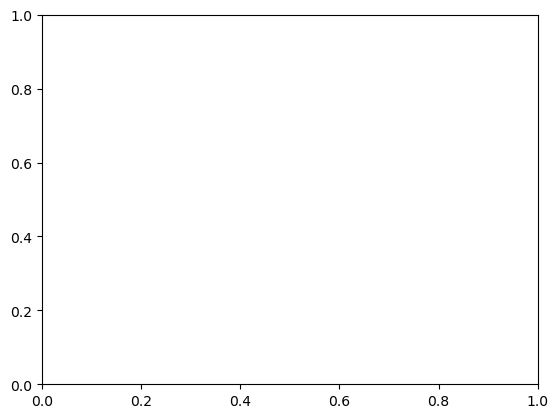

In [28]:
plt.plot(num_epoch, train_loss_hist, 'bo', label='Training loss')
plt.plot(num_epoch, train_acc_hist, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
plt.plot(num_epoch, train_lr_hist, 'b', label='Learning rate')
plt.title('Training and validation loss')
plt.legend()